In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import deepmatcher as dm
import pandas as pd
import numpy as np
from utils.mojito2 import aggregateRankings
from utils.explainer import Explainer
from collections import OrderedDict
import matplotlib.pyplot as plt

# Calculate rankings

## Itunes-Amazon

In [2]:
itunes_model = dm.MatchingModel(attr_summarizer='rnn')
itunes_model.load_state('models/itunes_amazon_rnn.pth')
itunes_model = itunes_model.to('cuda')

In [3]:
itunes_explainer = Explainer(itunes_model,[])

In [4]:
ITUNES_DIR = 'datasets/Structured/itunes-amazon/'

In [5]:
neg_rankings_itunes,flipped_neg_itunes = itunes_explainer.getRankingsBlackBox(ITUNES_DIR,0,2,augment_test=True)

100%|██████████| 51/51 [01:11<00:00,  1.41s/it]


In [6]:
pos_rankings_itunes,flippedPos_itunes = itunes_explainer.getRankingsBlackBox(ITUNES_DIR,1,2,augment_test=True)

100%|██████████| 51/51 [01:11<00:00,  1.41s/it]


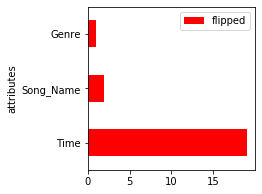

In [7]:
plt,negRank = aggregateRankings(neg_rankings_itunes,positive=False,maxLenAttributes=1)

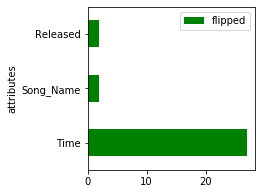

In [8]:
plt,posRank = aggregateRankings(pos_rankings_itunes,positive=True,maxLenAttributes=1)

### Retrain model

In [81]:
augmented_train = prepareDataset(train_df,tableA_itunes,tableB_itunes,40)

In [82]:
len(train_df)

321

In [83]:
len(augmented_train)

339

In [86]:
train_predictions = wrapDm(augmented_train,itunes_model,ignore_columns=['ltable_id','rtable_id','id','label'])
tp_group = augmented_train[(train_predictions[:,1]>=0.5)& augmented_train['label'] == 1]
tn_group = augmented_train[(train_predictions[:,0] >=0.5)& augmented_train['label']==0]
correctPredictions_train_itunes = pd.concat([tp_group,tn_group])

In [87]:
pos_rankings_itunes,pos_triangles_itunes,flippedPredictions_pos = explainSamples(correctPredictions_train_itunes,
                                                          [tableA_itunes,tableB_itunes],
                                                          itunes_model,originalClass=1)

100%|██████████| 86/86 [03:38<00:00,  2.54s/it]


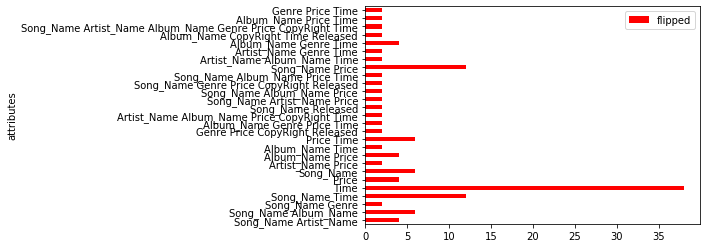

In [118]:
aggregateRankings(pos_rankings_itunes)

In [205]:
newTrainingSamples = flippedPredictions_pos[(flippedPredictions_pos.alteredAttribute==('Genre','Price','Time'))|
                      (flippedPredictions_pos.alteredAttribute==('Time',))|
                       (flippedPredictions_pos.alteredAttribute==('Price','Time'))|
                                            (flippedPredictions_pos.alteredAttribute==('Price',))].sample(n=100)

In [206]:
def adjustNewTraining(df):
    newTrainingSamples = df.copy().drop_duplicates(subset=['ltable_id','rtable_id'])
    newTrainingSamples['label'] = 1
    oldCol = [col for col in list(newTrainingSamples) if col not in ['ltable_id','rtable_id','label']]
    newCols = ['ltable_id','rtable_id','label'] + oldCol
    newTrainingSamples = newTrainingSamples[newCols]
    newTrainingSamples = newTrainingSamples.drop(['alteredAttribute'],axis=1)
    return newTrainingSamples

In [207]:
newTrain_correct = adjustNewTraining(newTrainingSamples)
newTrain_correct.to_csv('datasets/Structured/itunes-amazon/mojito_newtrain.csv',index=False)

In [208]:
train_df,valid_df,test_df = generate_train_valid_test(ITUNES_DIR,['train.csv','valid.csv','test.csv'],
                                                     left_prefix='ltable_',right_prefix='rtable_',drop_lrid=False)

In [210]:
valid_df.to_csv(ITUNES_DIR+'valid_withid.csv',index=False)
test_df.to_csv(ITUNES_DIR+'test_withid.csv',index=False)

In [209]:
improved_train = pd.concat([train_df,newTrain_correct])
improved_train.to_csv(ITUNES_DIR+'improved_train.csv',index=False)
improved_train.shape,train_df.shape

((343, 20), (321, 20))

In [214]:
train,validation,test = dm.data.process(ITUNES_DIR,train='improved_train.csv',validation='valid_withid.csv',
                                       test='test_withid.csv',left_prefix='ltable_',right_prefix='rtable_',cache='impr.pth',
                                       ignore_columns = ['ltable_id','rtable_id'])


Reading and processing data from "datasets/Structured/itunes-amazon/improved_train.csv"
0% [############################# ] 100% | ETA: 00:00:00
Reading and processing data from "datasets/Structured/itunes-amazon/valid_withid.csv"
0% [############################# ] 100% | ETA: 00:00:00
Reading and processing data from "datasets/Structured/itunes-amazon/test_withid.csv"
0% [############################# ] 100% | ETA: 00:00:00
Building vocabulary
0% [#] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00

Computing principal components
0% [#] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


In [215]:
impr_model = dm.MatchingModel(attr_summarizer='hybrid')
impr_model.run_train(train,validation,epochs=25,pos_neg_ratio= 4,best_save_path='models/itunes_amazon_hybrid_impr.pth')

* Number of trainable parameters: 17757810
===>  TRAIN Epoch 1


/home/nvidia/anaconda3/envs/torchenv/lib/python3.6/site-packages/torch/nn/functional.py:1932: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


Finished Epoch 1 || Run Time:    5.3 | Load Time:    2.3 || F1:  46.55 | Prec:  31.27 | Rec:  91.00 || Ex/s:  44.85

===>  EVAL Epoch 1
Finished Epoch 1 || Run Time:    0.6 | Load Time:    0.6 || F1:  43.70 | Prec:  28.26 | Rec:  96.30 || Ex/s:  90.95

* Best F1: tensor(43.6975, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 2


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 2 || Run Time:    4.6 | Load Time:    1.7 || F1:  52.57 | Prec:  36.06 | Rec:  97.00 || Ex/s:  54.79

===>  EVAL Epoch 2
Finished Epoch 2 || Run Time:    0.5 | Load Time:    0.5 || F1:  56.76 | Prec:  44.68 | Rec:  77.78 || Ex/s: 106.99

* Best F1: tensor(56.7568, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 3


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 3 || Run Time:    4.6 | Load Time:    1.7 || F1:  68.20 | Prec:  55.28 | Rec:  89.00 || Ex/s:  54.37

===>  EVAL Epoch 3
Finished Epoch 3 || Run Time:    0.5 | Load Time:    0.5 || F1:  63.89 | Prec:  51.11 | Rec:  85.19 || Ex/s: 108.61

* Best F1: tensor(63.8889, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 4


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 4 || Run Time:    4.6 | Load Time:    1.7 || F1:  77.73 | Prec:  65.31 | Rec:  96.00 || Ex/s:  54.56

===>  EVAL Epoch 4
Finished Epoch 4 || Run Time:    0.5 | Load Time:    0.5 || F1:  68.57 | Prec:  55.81 | Rec:  88.89 || Ex/s: 110.90

* Best F1: tensor(68.5714, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 5


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


Finished Epoch 5 || Run Time:    5.4 | Load Time:    2.3 || F1:  81.17 | Prec:  69.78 | Rec:  97.00 || Ex/s:  44.69

===>  EVAL Epoch 5
Finished Epoch 5 || Run Time:    0.6 | Load Time:    0.6 || F1:  73.53 | Prec:  60.98 | Rec:  92.59 || Ex/s:  95.10

* Best F1: tensor(73.5294, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 6


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 6 || Run Time:    4.9 | Load Time:    1.9 || F1:  89.69 | Prec:  81.30 | Rec: 100.00 || Ex/s:  50.88

===>  EVAL Epoch 6
Finished Epoch 6 || Run Time:    0.6 | Load Time:    0.6 || F1:  78.12 | Prec:  67.57 | Rec:  92.59 || Ex/s:  93.47

* Best F1: tensor(78.1250, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 7


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 7 || Run Time:    5.1 | Load Time:    2.0 || F1:  93.90 | Prec:  88.50 | Rec: 100.00 || Ex/s:  48.49

===>  EVAL Epoch 7
Finished Epoch 7 || Run Time:    0.6 | Load Time:    0.6 || F1:  79.37 | Prec:  69.44 | Rec:  92.59 || Ex/s:  94.56

* Best F1: tensor(79.3651, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 8


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 8 || Run Time:    4.5 | Load Time:    1.7 || F1:  97.09 | Prec:  94.34 | Rec: 100.00 || Ex/s:  55.92

===>  EVAL Epoch 8
Finished Epoch 8 || Run Time:    0.5 | Load Time:    0.5 || F1:  80.00 | Prec:  68.42 | Rec:  96.30 || Ex/s: 110.65

* Best F1: tensor(80., device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 9


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 9 || Run Time:    5.0 | Load Time:    1.9 || F1:  99.01 | Prec:  98.04 | Rec: 100.00 || Ex/s:  49.80

===>  EVAL Epoch 9
Finished Epoch 9 || Run Time:    0.6 | Load Time:    0.6 || F1:  74.29 | Prec:  60.47 | Rec:  96.30 || Ex/s:  93.53

---------------------

===>  TRAIN Epoch 10


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 10 || Run Time:    4.8 | Load Time:    1.8 || F1:  99.01 | Prec:  98.04 | Rec: 100.00 || Ex/s:  51.76

===>  EVAL Epoch 10
Finished Epoch 10 || Run Time:    0.6 | Load Time:    0.6 || F1:  81.25 | Prec:  70.27 | Rec:  96.30 || Ex/s:  94.48

* Best F1: tensor(81.2500, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 11


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


Finished Epoch 11 || Run Time:    5.4 | Load Time:    2.3 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  44.79

===>  EVAL Epoch 11
Finished Epoch 11 || Run Time:    0.6 | Load Time:    0.6 || F1:  78.79 | Prec:  66.67 | Rec:  96.30 || Ex/s:  94.29

---------------------

===>  TRAIN Epoch 12


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


Finished Epoch 12 || Run Time:    5.3 | Load Time:    2.2 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  46.08

===>  EVAL Epoch 12
Finished Epoch 12 || Run Time:    0.6 | Load Time:    0.6 || F1:  81.25 | Prec:  70.27 | Rec:  96.30 || Ex/s:  93.22

---------------------

===>  TRAIN Epoch 13


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 13 || Run Time:    4.4 | Load Time:    1.6 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  56.53

===>  EVAL Epoch 13
Finished Epoch 13 || Run Time:    0.5 | Load Time:    0.5 || F1:  80.00 | Prec:  68.42 | Rec:  96.30 || Ex/s: 111.11

---------------------

===>  TRAIN Epoch 14


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


Finished Epoch 14 || Run Time:    5.2 | Load Time:    2.0 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  47.16

===>  EVAL Epoch 14
Finished Epoch 14 || Run Time:    0.6 | Load Time:    0.6 || F1:  80.00 | Prec:  68.42 | Rec:  96.30 || Ex/s:  93.58

---------------------

===>  TRAIN Epoch 15


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


Finished Epoch 15 || Run Time:    5.4 | Load Time:    2.2 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  45.47

===>  EVAL Epoch 15
Finished Epoch 15 || Run Time:    0.6 | Load Time:    0.6 || F1:  80.00 | Prec:  68.42 | Rec:  96.30 || Ex/s:  93.86

---------------------

===>  TRAIN Epoch 16


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 16 || Run Time:    4.4 | Load Time:    1.6 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  56.38

===>  EVAL Epoch 16
Finished Epoch 16 || Run Time:    0.5 | Load Time:    0.5 || F1:  80.00 | Prec:  68.42 | Rec:  96.30 || Ex/s: 110.91

---------------------

===>  TRAIN Epoch 17


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 17 || Run Time:    4.6 | Load Time:    1.6 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  55.17

===>  EVAL Epoch 17
Finished Epoch 17 || Run Time:    0.5 | Load Time:    0.5 || F1:  80.00 | Prec:  68.42 | Rec:  96.30 || Ex/s: 109.19

---------------------

===>  TRAIN Epoch 18


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 18 || Run Time:    4.5 | Load Time:    1.6 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  56.01

===>  EVAL Epoch 18
Finished Epoch 18 || Run Time:    0.5 | Load Time:    0.5 || F1:  80.00 | Prec:  68.42 | Rec:  96.30 || Ex/s: 111.12

---------------------

===>  TRAIN Epoch 19


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


Finished Epoch 19 || Run Time:    5.5 | Load Time:    2.2 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  44.78

===>  EVAL Epoch 19
Finished Epoch 19 || Run Time:    0.6 | Load Time:    0.6 || F1:  80.00 | Prec:  68.42 | Rec:  96.30 || Ex/s:  94.84

---------------------

===>  TRAIN Epoch 20


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 20 || Run Time:    4.6 | Load Time:    1.6 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  54.91

===>  EVAL Epoch 20
Finished Epoch 20 || Run Time:    0.5 | Load Time:    0.5 || F1:  80.00 | Prec:  68.42 | Rec:  96.30 || Ex/s: 111.31

---------------------

===>  TRAIN Epoch 21


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 21 || Run Time:    4.5 | Load Time:    1.6 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  55.43

===>  EVAL Epoch 21
Finished Epoch 21 || Run Time:    0.6 | Load Time:    0.6 || F1:  80.00 | Prec:  68.42 | Rec:  96.30 || Ex/s:  94.04

---------------------

===>  TRAIN Epoch 22


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 22 || Run Time:    4.6 | Load Time:    1.7 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  54.61

===>  EVAL Epoch 22
Finished Epoch 22 || Run Time:    0.5 | Load Time:    0.5 || F1:  80.00 | Prec:  68.42 | Rec:  96.30 || Ex/s: 111.05

---------------------

===>  TRAIN Epoch 23


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 23 || Run Time:    4.9 | Load Time:    1.9 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  50.48

===>  EVAL Epoch 23
Finished Epoch 23 || Run Time:    0.6 | Load Time:    0.6 || F1:  80.00 | Prec:  68.42 | Rec:  96.30 || Ex/s:  93.55

---------------------

===>  TRAIN Epoch 24


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 24 || Run Time:    4.4 | Load Time:    1.6 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  56.47

===>  EVAL Epoch 24
Finished Epoch 24 || Run Time:    0.5 | Load Time:    0.5 || F1:  80.00 | Prec:  68.42 | Rec:  96.30 || Ex/s: 110.99

---------------------

===>  TRAIN Epoch 25


0% [██] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


Finished Epoch 25 || Run Time:    4.6 | Load Time:    1.6 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  55.18

===>  EVAL Epoch 25
Finished Epoch 25 || Run Time:    0.5 | Load Time:    0.5 || F1:  80.00 | Prec:  68.42 | Rec:  96.30 || Ex/s: 109.22

---------------------

Loading best model...
Training done.


tensor(81.2500, device='cuda:0')

In [216]:
impr_model.run_eval(test)

===>  EVAL Epoch 10
Finished Epoch 10 || Run Time:    0.6 | Load Time:    0.6 || F1:  85.19 | Prec:  85.19 | Rec:  85.19 || Ex/s:  90.10



tensor(85.1852, device='cuda:0')

### Evaluate ranking on new model

In [217]:
augmented_test = prepareDataset(test_df,tableA_itunes,tableB_itunes,30)

In [218]:
predictions = wrapDm(augmented_test,impr_model,ignore_columns=['ltable_id','rtable_id','id','label'])
tp_group = augmented_test[(predictions[:,1]>=0.5)& augmented_test['label'] == 1]
tn_group = augmented_test[(predictions[:,0] >=0.5)& augmented_test['label']==0]
correctPredictions_itunes = pd.concat([tp_group,tn_group])

In [239]:
pos_rankings_itunes,pos_triangles_itunes,flippedPredictions_pos = explainSamples(correctPredictions_itunes,
                                                          [tableA_itunes,tableB_itunes],
                                                          impr_model,originalClass=1)

100%|██████████| 48/48 [01:47<00:00,  2.24s/it]


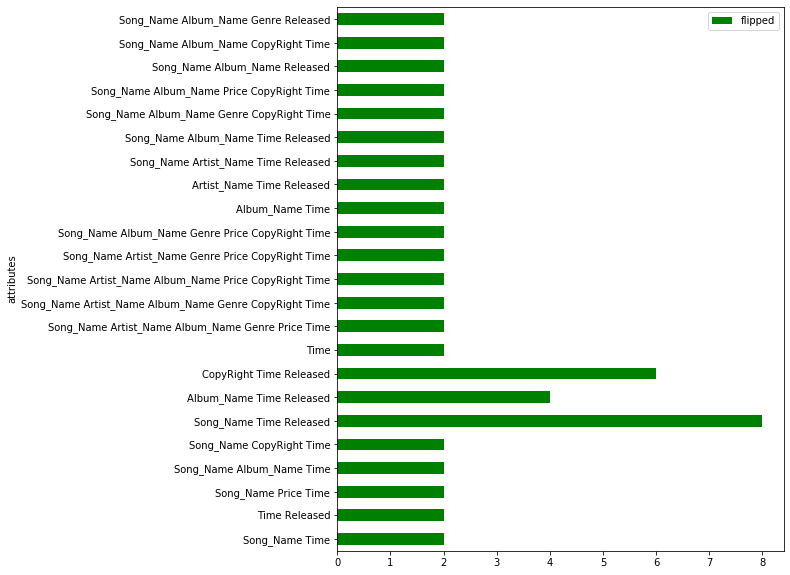

In [240]:
aggregateRankings(pos_rankings_itunes,positive=True)

## Beer

In [53]:
beer_model = dm.MatchingModel(attr_summarizer='hybrid')
beer_model.load_state('models/beer_hybrid.pth')
beer_model = beer_model.to('cuda')

In [54]:
tableA_beer = pd.read_csv('datasets/Structured/Beer/tableA.csv')
tableB_beer = pd.read_csv('datasets/Structured/Beer/tableB.csv')

In [55]:
BEER_DIR ='datasets/Structured/Beer/'
train_df,validation_df,test_df = generate_train_valid_test(BEER_DIR,['train.csv','valid.csv','test.csv']
                                                      ,left_prefix='ltable_',right_prefix='rtable_',
                                                          drop_lrid=False)

In [8]:
augment_test = prepareDataset(test_df,tableA_beer,tableB_beer,20)
len(augment_test),len(test_df)

(105, 91)

In [56]:
augment_test = pd.read_csv(BEER_DIR+'augmented_test.csv')

In [57]:
predictions = wrapDm(augment_test,beer_model,ignore_columns=['ltable_id','rtable_id','id','label'])
tp_group = augment_test[(predictions[:,1]>=0.5)& (augment_test['label'] == 1)]
tn_group = augment_test[(predictions[:,0] >=0.5)& (augment_test['label']==0)]
correctPredictions_beer = pd.concat([tp_group,tn_group])

In [59]:
rankings_beer_pos,_,pos_flipped_beer,notFlipped_pos_beer = explainSamples(
    correctPredictions_beer,[tableA_beer,tableB_beer],
    beer_model,originalClass=1,maxLenAttributeSet=1)


100%|██████████| 38/38 [00:13<00:00,  2.74it/s]


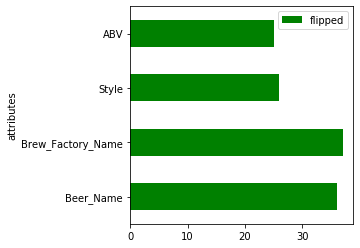

In [61]:
ax,plot = aggregateRankings(rankings_beer_pos,positive=True,maxLenAttributes=1)

In [62]:
rankings_beer_neg,neg_triangles_beer,negFlippedBeer,notFlipped_neg_beer = explainSamples(
    correctPredictions_beer,[tableA_beer,tableB_beer],
                                    beer_model,originalClass=0,maxLenAttributeSet=1)


100%|██████████| 38/38 [00:14<00:00,  2.70it/s]


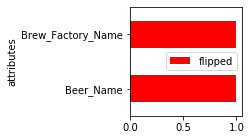

In [64]:
ax,plot = aggregateRankings(rankings_beer_neg,positive=False,maxLenAttributes=1)

In [19]:
negFlippedBeer[negFlippedBeer.alteredAttribute==('Beer_Name',)]

,ltable_id,ltable_Beer_Name,ltable_Brew_Factory_Name,ltable_Style,ltable_ABV,rtable_id,rtable_Beer_Name,rtable_Brew_Factory_Name,rtable_Style,rtable_ABV,id,alteredAttribute
0,1284,Bainbridge Island Arrow Point Amber,Bainbridge Island Brewing Company,Amber Ale,5.40 %,548,Arrow Point Amber,Third Base Sports Bar & Brewery,Amber Ale,4.60 %,0,"(Beer_Name,)"
0,1284,Bainbridge Island Arrow Point Amber,Bainbridge Island Brewing Company,Amber Ale,5.40 %,548,Arrow Point Amber,Third Base Sports Bar & Brewery,Amber Ale,4.60 %,0,"(Beer_Name,)"


## Walmart-Amazon

In [3]:
walmart_model = dm.MatchingModel(attr_summarizer='rnn')
walmart_model.load_state('models/walmartamazon_rnn.pth')
walmart_model = walmart_model.to('cuda')

In [4]:
WALMART_DIR = 'datasets/Structured/Walmart-Amazon/'

In [5]:
walmart_explainer = Explainer(walmart_model,[])

In [6]:
from utils.dataset_parser import generateDataset
test_withid = generateDataset(WALMART_DIR,'tableA.csv','tableB.csv','test.csv','ltable_','rtable_')

In [7]:
neg_rankings_wal,flippedNeg_walm = walmart_explainer.getRankingsBlackBox(WALMART_DIR,test_withid,0,2,False)

100%|██████████| 129/129 [01:16<00:00,  1.68it/s]


In [8]:
pos_rankings_wal,flippedPos_walmart = walmart_explainer.getRankingsBlackBox(WALMART_DIR,test_withid,1,2,False)

100%|██████████| 129/129 [01:16<00:00,  1.69it/s]


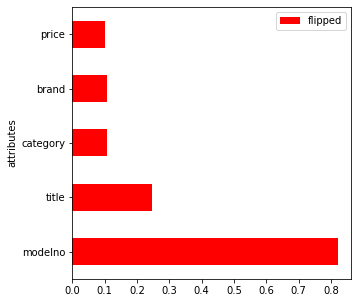

In [10]:
plot,negrankings = aggregateRankings(neg_rankings_wal,positive=False,maxLenAttributes=1,lenTriangles=129)

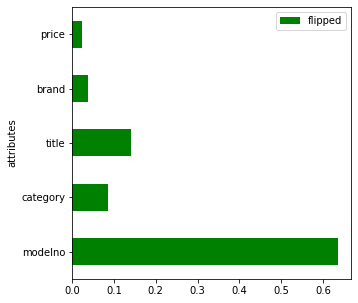

In [11]:
plot,posrankings = aggregateRankings(pos_rankings_wal,positive=True,maxLenAttributes=1,lenTriangles=129)

In [48]:
newPositives = pd.concat([flippedNeg_walmart,notFlippedPos_walmart],ignore_index=True)
newNegatives = pd.concat([flippedPos_walmart,notFlippedNeg_walmart],ignore_index=True)
extendedNeg,extendedPos= extendDatasets(WALMART_DIR,newNegatives,newPositives)
len(negatives),len(extendedNeg),len(positives),len(extendedPos)

(9280, 11869, 962, 3333)

In [49]:
extendedNeg.to_csv(WALMART_DIR+'extended_negatives.csv',index=False)
extendedPos.to_csv(WALMART_DIR+'extended_positives.csv',index=False)

### Mine patterns

In [44]:
modelnoIsEqual = 0
df = flippedNeg_walmart[flippedNeg_walmart.alteredAttribute==('modelno',)]
lmodelno = df.ltable_modelno.values
rmodelno = df.rtable_modelno.values
for l,r in zip(lmodelno,rmodelno):
    if l==r :
        modelnoIsEqual +=1
modelnoIsEqual/len(lmodelno)

0.9366754617414248

## Amazon-Google

In [19]:
GOOGLE_DIR = 'datasets/Structured/Amazon-Google/'

### RNN

In [9]:
google_rnn = dm.MatchingModel(attr_summarizer='rnn')
google_rnn.load_state('models/amazongoogle_rnn.pth')
google_rnn = google_rnn.to('cuda')

In [7]:
predictions = wrapDm(test_df,google_rnn,ignore_columns=['ltable_id','rtable_id','id','label'])
tp_group = test_df[(predictions[:,1]>=0.5)& (test_df['label'] == 1)]
tn_group = test_df[(predictions[:,0] >=0.5)& (test_df['label']==0)]

In [8]:
correctPredictions_google = pd.concat([tp_group,tn_group])
correctPredictions_google.shape

(2099, 10)

In [10]:
negrankings_google,neg_triangles_google,flippedPredictions_neg_google,notFlipped_neg_google = explainSamples(correctPredictions_google,
                                                          [tableA_google,tableB_google],google_rnn,originalClass=0,
                                                                                       maxLenAttributeSet=2)

100%|██████████| 426/426 [01:18<00:00,  5.41it/s]


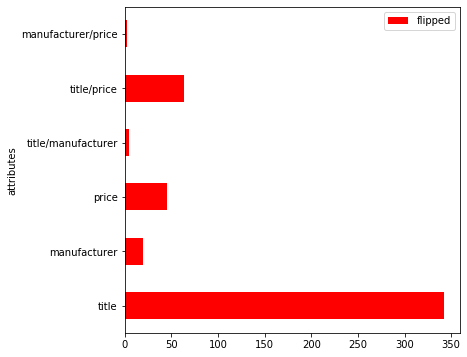

In [14]:
plot,negrank = aggregateRankings(negrankings_google,positive=False,maxLenAttributes=2)

In [15]:
pos_rankings_google,pos_triangles_google,flipped_pos_google,notflipped_pos_google = explainSamples(correctPredictions_google,
                                                          [tableA_google,tableB_google],google_rnn,originalClass=1,
                                                                                                  maxLenAttributeSet=2)

100%|██████████| 426/426 [01:18<00:00,  5.44it/s]


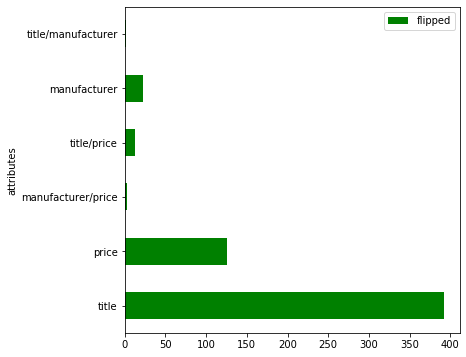

In [17]:
plot,posrank = aggregateRankings(pos_rankings_google,positive=True,maxLenAttributes=2)

### Mine patterns

In [42]:
flippedOnPrice = flipped_pos_google[flipped_pos_google.alteredAttribute==('price',)]
flippedOnPrice['rtable_price'].value_counts()

399.00     5
29.99      4
69.95      4
299.99     4
199.00     4
          ..
125.99     1
23.53      1
1025.99    1
308.99     1
39.92      1
Name: rtable_price, Length: 84, dtype: int64

In [43]:
amazongoogle_train_pos = train_df[train_df.label==1]
ltablePrices = amazongoogle_train_pos.ltable_price.values
rtablePrices = amazongoogle_train_pos.rtable_price.values

In [50]:
np.count_nonzero(train_df[train_df.label==0].ltable_price.values==399)

101

In [51]:
np.count_nonzero(train_df[train_df.label==0].rtable_price.values==399)

0

In [49]:
import numpy as np
np.count_nonzero(ltablePrices == 399.00)

2

In [39]:
flippedOnPrice['ltable_price'].value_counts()

99.95      14
649.00     12
219.99     11
89.99      11
199.00     10
205.99      7
19.99       7
249.00      6
239.99      5
29.99       4
499.99      4
89.95       4
998.95      3
34.97       3
1799.00     3
17.97       2
45.99       2
699.00      2
369.09      2
1199.00     2
699.99      1
158.39      1
299.95      1
85.07       1
119.99      1
299.99      1
499.00      1
43.32       1
18.97       1
34.99       1
399.00      1
Name: ltable_price, dtype: int64

#### Retrain model

In [25]:
train_predictions = wrapDm(train_df,google_rnn,ignore_columns=['ltable_id','rtable_id','id','label'])
tp_group = train_df[(train_predictions[:,1]>=0.5)& train_df['label'] == 1]
tn_group = train_df[(train_predictions[:,0] >=0.5)& train_df['label']==0]

In [26]:
correct_trainPred_google = pd.concat([tp_group,tn_group])
correct_trainPred_google_sample = correct_trainPred_google.sample(frac=0.5)

In [27]:
pos_rankings_train_google,pos_triangles_google,flippedPredictions_pos_google_train = explainSamples(correct_trainPred_google_sample,
                                                          [tableA_google,tableB_google],google_rnn,originalClass=1)

TypeError: explainSamples() missing 1 required positional argument: 'maxLenAttributeSet'

In [357]:
newTrainingSamples = flippedPredictions_pos_google_train[(flippedPredictions_pos_google_train.alteredAttribute==('price',))]

In [358]:
newTrain_correct = adjustNewTraining(newTrainingSamples)
newTrain_correct.to_csv('datasets/Structured/Amazon-Google/mojito_newtrain.csv',index=False)
newTrain_correct.shape

(83, 10)

In [359]:
train_df,valid_df,test_df = generate_train_valid_test(GOOGLE_DIR,['train.csv','valid.csv','test.csv'],
                                                     left_prefix='ltable_',right_prefix='rtable_',drop_lrid=False)

In [360]:
valid_df.to_csv(GOOGLE_DIR+'valid_withid.csv',index=False)
test_df.to_csv(GOOGLE_DIR+'test_withid.csv',index=False)
improved_train = pd.concat([train_df,newTrain_correct])
improved_train.to_csv(GOOGLE_DIR+'improved_train_rnn.csv',index=False)

In [361]:
train,validation,test = dm.data.process(GOOGLE_DIR,train='improved_train_rnn.csv',validation='valid_withid.csv',
                                       test='test_withid.csv',cache='impr.pth',left_prefix='ltable_',
                                       right_prefix='rtable_',ignore_columns=['ltable_id','rtable_id'])


Reading and processing data from "datasets/Structured/Amazon-Google/improved_train_rnn.csv"
0% [############################# ] 100% | ETA: 00:00:00
Reading and processing data from "datasets/Structured/Amazon-Google/valid_withid.csv"
0% [############################# ] 100% | ETA: 00:00:00
Reading and processing data from "datasets/Structured/Amazon-Google/test_withid.csv"
0% [############################# ] 100% | ETA: 00:00:00
Building vocabulary
0% [#######] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00

Computing principal components
0% [#######] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


In [362]:
impr_rnn_google = dm.MatchingModel(attr_summarizer='rnn')
impr_rnn_google.run_train(train,validation,epochs=20,best_save_path='models/amazongoogle_rnn_impr.pth',
                         pos_neg_ratio=10)

* Number of trainable parameters: 1762802
===>  TRAIN Epoch 1


/home/nvidia/anaconda3/envs/torchenv/lib/python3.6/site-packages/torch/nn/functional.py:1932: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:14


Finished Epoch 1 || Run Time:    6.9 | Load Time:    7.5 || F1:  23.72 | Prec:  13.57 | Rec:  94.12 || Ex/s: 480.97

===>  EVAL Epoch 1


0% [██████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03


Finished Epoch 1 || Run Time:    0.9 | Load Time:    2.3 || F1:  32.50 | Prec:  20.37 | Rec:  80.34 || Ex/s: 721.08

* Best F1: tensor(32.4978, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 2


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:14


Finished Epoch 2 || Run Time:    6.9 | Load Time:    7.5 || F1:  35.91 | Prec:  22.06 | Rec:  96.55 || Ex/s: 482.33

===>  EVAL Epoch 2


0% [██████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03


Finished Epoch 2 || Run Time:    0.9 | Load Time:    2.3 || F1:  43.18 | Prec:  29.24 | Rec:  82.48 || Ex/s: 722.18

* Best F1: tensor(43.1767, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 3


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:14


Finished Epoch 3 || Run Time:    6.9 | Load Time:    7.5 || F1:  52.66 | Prec:  35.99 | Rec:  98.08 || Ex/s: 481.69

===>  EVAL Epoch 3


0% [██████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03


Finished Epoch 3 || Run Time:    0.9 | Load Time:    2.3 || F1:  53.53 | Prec:  40.35 | Rec:  79.49 || Ex/s: 717.49

* Best F1: tensor(53.5252, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 4


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:14


Finished Epoch 4 || Run Time:    6.9 | Load Time:    7.5 || F1:  67.10 | Prec:  50.82 | Rec:  98.72 || Ex/s: 481.66

===>  EVAL Epoch 4


0% [██████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03


Finished Epoch 4 || Run Time:    0.9 | Load Time:    2.3 || F1:  52.28 | Prec:  38.65 | Rec:  80.77 || Ex/s: 720.92

---------------------

===>  TRAIN Epoch 5


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:14


Finished Epoch 5 || Run Time:    7.0 | Load Time:    7.5 || F1:  77.96 | Prec:  64.09 | Rec:  99.49 || Ex/s: 479.31

===>  EVAL Epoch 5


0% [██████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03


Finished Epoch 5 || Run Time:    0.9 | Load Time:    2.3 || F1:  56.42 | Prec:  43.35 | Rec:  80.77 || Ex/s: 721.76

* Best F1: tensor(56.4179, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 6


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:14


Finished Epoch 6 || Run Time:    6.9 | Load Time:    7.5 || F1:  85.76 | Prec:  75.22 | Rec:  99.74 || Ex/s: 481.84

===>  EVAL Epoch 6


0% [██████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03


Finished Epoch 6 || Run Time:    0.9 | Load Time:    2.3 || F1:  58.88 | Prec:  47.86 | Rec:  76.50 || Ex/s: 711.58

* Best F1: tensor(58.8816, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 7


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:14


Finished Epoch 7 || Run Time:    6.9 | Load Time:    7.5 || F1:  89.97 | Prec:  81.93 | Rec:  99.74 || Ex/s: 481.75

===>  EVAL Epoch 7


0% [██████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03


Finished Epoch 7 || Run Time:    0.9 | Load Time:    2.3 || F1:  59.41 | Prec:  55.35 | Rec:  64.10 || Ex/s: 719.16

* Best F1: tensor(59.4059, device='cuda:0')
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 8


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:22


Finished Epoch 8 || Run Time:   11.8 | Load Time:   10.9 || F1:  92.00 | Prec:  85.19 | Rec: 100.00 || Ex/s: 306.60

===>  EVAL Epoch 8


0% [██████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03


Finished Epoch 8 || Run Time:    1.0 | Load Time:    2.4 || F1:  58.15 | Prec:  53.82 | Rec:  63.25 || Ex/s: 673.70

---------------------

===>  TRAIN Epoch 9


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:22


Finished Epoch 9 || Run Time:   11.8 | Load Time:   10.7 || F1:  93.71 | Prec:  88.16 | Rec: 100.00 || Ex/s: 309.06

===>  EVAL Epoch 9


0% [██████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03


Finished Epoch 9 || Run Time:    0.9 | Load Time:    2.3 || F1:  59.29 | Prec:  55.15 | Rec:  64.10 || Ex/s: 725.90

---------------------

===>  TRAIN Epoch 10


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:22


Finished Epoch 10 || Run Time:   12.2 | Load Time:   11.0 || F1:  94.56 | Prec:  89.68 | Rec: 100.00 || Ex/s: 299.83

===>  EVAL Epoch 10


0% [██████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03


Finished Epoch 10 || Run Time:    0.9 | Load Time:    2.3 || F1:  57.20 | Prec:  53.76 | Rec:  61.11 || Ex/s: 720.54

---------------------

===>  TRAIN Epoch 11


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:22


Finished Epoch 11 || Run Time:   12.1 | Load Time:   10.9 || F1:  95.77 | Prec:  91.89 | Rec: 100.00 || Ex/s: 303.63

===>  EVAL Epoch 11


0% [██████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03


Finished Epoch 11 || Run Time:    1.0 | Load Time:    2.5 || F1:  57.95 | Prec:  54.75 | Rec:  61.54 || Ex/s: 670.45

---------------------

===>  TRAIN Epoch 12


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:22


Finished Epoch 12 || Run Time:   12.2 | Load Time:   11.1 || F1:  96.42 | Prec:  93.10 | Rec: 100.00 || Ex/s: 298.88

===>  EVAL Epoch 12


0% [██████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03


Finished Epoch 12 || Run Time:    1.0 | Load Time:    2.5 || F1:  58.12 | Prec:  54.72 | Rec:  61.97 || Ex/s: 672.40

---------------------

===>  TRAIN Epoch 13


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:21


Finished Epoch 13 || Run Time:   11.4 | Load Time:   10.1 || F1:  96.90 | Prec:  93.99 | Rec: 100.00 || Ex/s: 324.54

===>  EVAL Epoch 13


0% [██████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03


Finished Epoch 13 || Run Time:    0.9 | Load Time:    2.3 || F1:  58.40 | Prec:  54.89 | Rec:  62.39 || Ex/s: 718.20

---------------------

===>  TRAIN Epoch 14


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:23


Finished Epoch 14 || Run Time:   12.3 | Load Time:   11.2 || F1:  97.02 | Prec:  94.22 | Rec: 100.00 || Ex/s: 295.72

===>  EVAL Epoch 14


0% [██████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03


Finished Epoch 14 || Run Time:    0.9 | Load Time:    2.3 || F1:  58.12 | Prec:  54.72 | Rec:  61.97 || Ex/s: 712.98

---------------------

===>  TRAIN Epoch 15


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:22


Finished Epoch 15 || Run Time:   11.8 | Load Time:   10.7 || F1:  97.20 | Prec:  94.56 | Rec: 100.00 || Ex/s: 309.73

===>  EVAL Epoch 15


0% [██████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03


Finished Epoch 15 || Run Time:    1.0 | Load Time:    2.5 || F1:  57.83 | Prec:  54.55 | Rec:  61.54 || Ex/s: 666.46

---------------------

===>  TRAIN Epoch 16


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:21


Finished Epoch 16 || Run Time:   11.6 | Load Time:   10.4 || F1:  97.32 | Prec:  94.79 | Rec: 100.00 || Ex/s: 316.60

===>  EVAL Epoch 16


0% [██████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03


Finished Epoch 16 || Run Time:    1.0 | Load Time:    2.5 || F1:  57.95 | Prec:  54.75 | Rec:  61.54 || Ex/s: 665.59

---------------------

===>  TRAIN Epoch 17


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:23


Finished Epoch 17 || Run Time:   12.3 | Load Time:   11.4 || F1:  97.32 | Prec:  94.79 | Rec: 100.00 || Ex/s: 293.40

===>  EVAL Epoch 17


0% [██████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03


Finished Epoch 17 || Run Time:    1.0 | Load Time:    2.5 || F1:  57.72 | Prec:  54.34 | Rec:  61.54 || Ex/s: 666.64

---------------------

===>  TRAIN Epoch 18


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:22


Finished Epoch 18 || Run Time:   12.1 | Load Time:   11.0 || F1:  97.32 | Prec:  94.79 | Rec: 100.00 || Ex/s: 301.90

===>  EVAL Epoch 18


0% [██████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03


Finished Epoch 18 || Run Time:    0.9 | Load Time:    2.4 || F1:  57.43 | Prec:  54.17 | Rec:  61.11 || Ex/s: 689.52

---------------------

===>  TRAIN Epoch 19


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:23


Finished Epoch 19 || Run Time:   12.3 | Load Time:   11.2 || F1:  97.32 | Prec:  94.79 | Rec: 100.00 || Ex/s: 295.91

===>  EVAL Epoch 19


0% [██████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03


Finished Epoch 19 || Run Time:    1.0 | Load Time:    2.5 || F1:  57.72 | Prec:  54.34 | Rec:  61.54 || Ex/s: 672.12

---------------------

===>  TRAIN Epoch 20


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:22


Finished Epoch 20 || Run Time:   11.8 | Load Time:   10.5 || F1:  97.38 | Prec:  94.90 | Rec: 100.00 || Ex/s: 312.06

===>  EVAL Epoch 20


0% [██████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03


Finished Epoch 20 || Run Time:    0.9 | Load Time:    2.3 || F1:  57.83 | Prec:  54.55 | Rec:  61.54 || Ex/s: 726.77

---------------------

Loading best model...
Training done.


tensor(59.4059, device='cuda:0')

In [363]:
impr_rnn_google.run_eval(test)

===>  EVAL Epoch 7


0% [██████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03


Finished Epoch 7 || Run Time:    0.9 | Load Time:    2.2 || F1:  63.75 | Prec:  59.70 | Rec:  68.38 || Ex/s: 733.63



tensor(63.7450, device='cuda:0')

#### Evaluate new model

In [364]:
predictions = wrapDm(test_df,impr_rnn_google,ignore_columns=['ltable_id','rtable_id','id','label'])
tp_group = test_df[(predictions[:,1]>=0.5)& test_df['label'] == 1]
tn_group = test_df[(predictions[:,0] >=0.5)& test_df['label']==0]
correctPredictions_google = pd.concat([tp_group,tn_group])

In [28]:
pos_rankings_google,pos_triangles_google,flippedPredictions_pos_google = explainSamples(correctPredictions_google,
                                                          [tableA_google,tableB_google],impr_rnn_google,originalClass=1,
                                                                                       maxLenAttributeSet=2)

NameError: name 'impr_rnn_google' is not defined

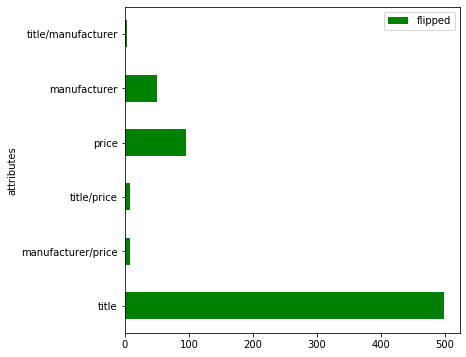

In [366]:
aggregateRankings(pos_rankings_google,True)

## DBLP-ACM

In [3]:
dblp_hybrid = dm.MatchingModel(attr_summarizer='hybrid')
dblp_hybrid.load_state('models/dblp_acm_hybrid2.pth')
dblp_hybrid = dblp_hybrid.to('cuda')

In [4]:
DBLP_DIR = 'datasets/Structured/DBLP-ACM/'
tableA_dblp = pd.read_csv(DBLP_DIR+'tableA.csv')
tableB_dblp = pd.read_csv(DBLP_DIR+'tableB.csv')

In [5]:
train_df,validation_df,test_df = generate_train_valid_test(DBLP_DIR,['train.csv','valid.csv','test.csv']
                                                          ,left_prefix='ltable_',right_prefix='rtable_',
                                                          drop_lrid=False)

In [6]:
predictions = wrapDm(test_df,dblp_hybrid,ignore_columns=['ltable_id','rtable_id','id','label'])
tp_group = test_df[(predictions[:,1]>=0.5)& (test_df['label'] == 1)]
tn_group = test_df[(predictions[:,0] >=0.5)& (test_df['label']==0)]
correctPredictions_dblp = pd.concat([tn_group,tp_group])

In [7]:
neg_rankings_dblp,_,flippedPred_neg_dblp,notflipped_neg_dblp= explainSamples(correctPredictions_dblp,
                                                          [tableA_dblp,tableB_dblp],dblp_hybrid,originalClass=0,
                                                                                              maxLenAttributeSet=1)

100%|██████████| 725/725 [05:27<00:00,  2.22it/s]


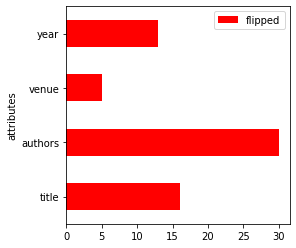

In [8]:
plot,negRanking_dblp = aggregateRankings(neg_rankings_dblp,positive=False,maxLenAttributes=1)

In [9]:
pos_rankings_dblp,_,flippedPred_pos_dblp,notflipped_pos_dblp = explainSamples(correctPredictions_dblp,
                                                          [tableA_dblp,tableB_dblp],dblp_hybrid,originalClass=1,
                                                                          maxLenAttributeSet=1)

100%|██████████| 725/725 [05:44<00:00,  2.10it/s]


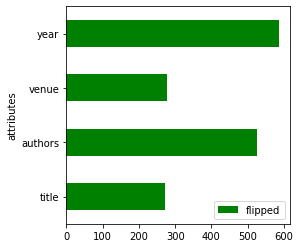

In [10]:
plot,ranking = aggregateRankings(pos_rankings_dblp,positive=True,maxLenAttributes=1)

In [73]:
newPos = pd.concat([notflipped_pos_dblp,flippedPred_neg_dblp],ignore_index=True)
newNeg = pd.concat([flippedPred_pos_dblp,notflipped_neg_dblp],ignore_index=True)
extendedNeg,extendedPos = extendDatasets(DBLP_DIR,newNeg,newPos)

In [75]:
extendedPos.to_csv(DBLP_DIR+'extended_positives.csv',index=False)
extendedNeg.to_csv(DBLP_DIR+'extended_negatives.csv',index=False)

In [76]:
len(extendedNeg),len(extendedPos)

(14288, 3851)

## DBLP-Scholar

In [3]:
scholar_hybrid = dm.MatchingModel(attr_summarizer='hybrid')
scholar_hybrid.load_state('models/dblp_scholar_hybrid.pth')
scholar_hybrid = scholar_hybrid.to('cuda')

In [4]:
DBLP_SCHOLAR_DIR = 'datasets/Structured/DBLP-GoogleScholar/'
tableA_scholar = pd.read_csv(DBLP_SCHOLAR_DIR+'tableA.csv')
tableB_scholar = pd.read_csv(DBLP_SCHOLAR_DIR+'tableB.csv')

In [5]:
train_df,validation_df,test_df = generate_train_valid_test(DBLP_SCHOLAR_DIR,['train.csv','valid.csv','test.csv']
                                                          ,left_prefix='ltable_',right_prefix='rtable_',
                                                          drop_lrid=False)

In [6]:
predictions = wrapDm(test_df,scholar_hybrid,ignore_columns=['ltable_id','rtable_id','id','label'])
tp_group = test_df[(predictions[:,1]>=0.5)& (test_df['label'] == 1)]
tn_group = test_df[(predictions[:,0] >=0.5)& (test_df['label']==0)]
correctPredictions_scholar = pd.concat([tn_group,tp_group])

In [8]:
neg_rankings_scholar,neg_triangles_scholar,flippedPred_neg_scholar= explainSamples(correctPredictions_scholar,
                                                          [tableA_scholar,tableB_scholar],
                                                                                   scholar_hybrid,originalClass=0,
                                                                                   maxLenAttributeSet=2)


 12%|█▏        | 303/2495 [04:41<37:49,  1.04s/it]


 24%|██▍       | 605/2495 [09:26<28:38,  1.10it/s]


 36%|███▋      | 907/2495 [14:17<24:22,  1.09it/s]


 48%|████▊     | 1205/2495 [19:01<19:37,  1.10it/s]


 60%|██████    | 1501/2495 [23:28<17:34,  1.06s/it]


 72%|███████▏  | 1797/2495 [27:57<10:11,  1.14it/s]


 84%|████████▍ | 2093/2495 [32:27<05:58,  1.12it/s]


 96%|█████████▌| 2389/2495 [36:50<01:33,  1.13it/s]


100%|██████████| 2495/2495 [38:25<00:00,  1.08it/s]


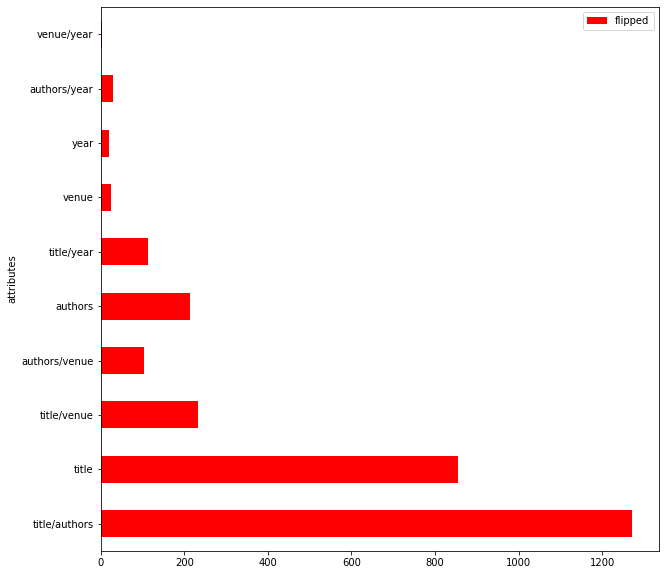

In [11]:
plot,negRanking_scholar = aggregateRankings(neg_rankings_scholar,positive=False,maxLenAttributes=2)

In [12]:
pos_rankings_scholar,pos_triangles_scholar,flippedPred_pos_scholar= explainSamples(correctPredictions_scholar,
                                                          [tableA_scholar,tableB_scholar],
                                                                                   scholar_hybrid,originalClass=1,
                                                                                   maxLenAttributeSet=2)


 12%|█▏        | 303/2495 [04:35<34:00,  1.07it/s]


 24%|██▍       | 605/2495 [09:09<28:14,  1.12it/s]


 36%|███▋      | 907/2495 [13:48<23:46,  1.11it/s]


 48%|████▊     | 1205/2495 [18:16<19:23,  1.11it/s]


 60%|██████    | 1501/2495 [22:46<15:16,  1.09it/s]


 72%|███████▏  | 1797/2495 [27:19<10:59,  1.06it/s]


 84%|████████▍ | 2093/2495 [31:55<06:02,  1.11it/s]


 96%|█████████▌| 2389/2495 [36:25<01:36,  1.10it/s]


100%|██████████| 2495/2495 [38:01<00:00,  1.09it/s]


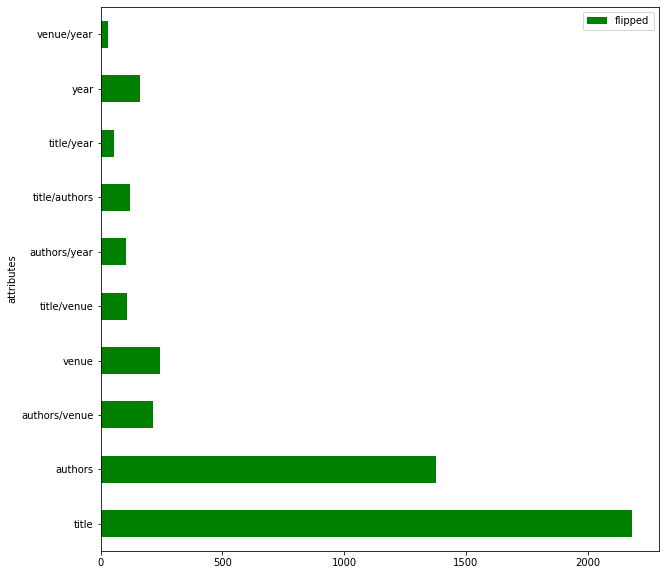

In [13]:
plot,posRanking_scholar = aggregateRankings(pos_rankings_scholar,positive=True,maxLenAttributes=2)

In [14]:
flippedPred_neg_scholar.to_csv('flippedpred_neg_scholar.csv',index=False)
flippedPred_pos_scholar.to_csv('flippedpred_pos_scholar.csv',index=False)